## Dependencies

In [9]:
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle
import os

os.chdir("../data")

## Reduce dataset size

<span style="color: #FF7777;"><strong>NOTE:</strong> The dataset is fairly large which can cause your system to slow down and even crash during code execution.<br>
It is highly recommended to run this cell to reduce the dataset size.</span>

In [28]:
max_images = 1000   # Maximum number of images for each animal
counter = {'cat': 0, 'dog': 0}

for filename in os.listdir("cat_dog"):
    animal, number = filename.split(".")[:2]
    if counter[animal] >= max_images:
        path = os.path.join("cat_dog", filename)
        os.remove(path)
    else:
        counter[animal] += 1

## Preprocessing

In [29]:
# === Import data ===
extension = ".jpg"
files = os.listdir("cat_dog")                                   # [cat.0.jpg, ...]
paths = [os.path.join("cat_dog", file) for file in files]       # [cat_dog/cat.0.jpg, ...]
names = [file.rstrip(extension) for file in files]              # [cat.0, ...]
images = [Image.open(path) for path in paths]                   # [PIL.Image.Image, ...]
IMAGES = {name: image for name, image in zip(names, images)}    # {'cat.0': PIL.Image.Image, ...}

In [30]:
# === Functional code ===
for name, image in IMAGES.items():
    IMAGES[name] = image.convert('L').resize((64, 64))

# Input: IMAGES
# Output: IMAGES

In [31]:
# === Export data ===
if not os.path.exists("preprocessed"):
    os.makedirs("preprocessed")

extension = ".jpg"
for name, image in IMAGES.items():                          # {'cat.0': PIL.Image.Image, ...}
    path = os.path.join("preprocessed", name + extension)   # 'preprocessed/cat.0.jpg'
    image.save(path)

## Train Test Split

In [32]:
# === Import data ===
extension = ".jpg"
files = os.listdir("preprocessed")                              # [cat.0.jpg, ...]
paths = [os.path.join("preprocessed", f) for f in files]        # [preprocessed/cat.0.jpg, ...]
names = [f.rstrip(extension) for f in files]                    # [cat.0, ...]
images = [Image.open(p) for p in paths]                         # [PIL.Image.Image, ...]
IMAGES = {name: image for name, image in zip(names, images)}    # {'cat.0': PIL.Image.Image, ...}

In [33]:
# === Functional code ===
features = [np.array(image) for image in IMAGES.values()]
classes = ['cat', 'dog']
targets = [classes.index(name.split(".")[0]) for name in IMAGES.keys()]
targets = [[t, 1-t] for t in targets]

features = np.array(features)
targets = np.array(targets)
features, targets = shuffle(features, targets)

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features, targets, test_size=0.15, random_state=42)

# Input: IMAGES
# Output: X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

In [34]:
# === Export data ===
if not os.path.exists("model_input"):
    os.makedirs("model_input")

with open("model_input/X_train.pkl", "wb") as f:
    pickle.dump(X_TRAIN, f)
with open("model_input/X_test.pkl", "wb") as f:
    pickle.dump(X_TEST, f)
with open("model_input/y_train.pkl", "wb") as f:
    pickle.dump(Y_TRAIN, f)
with open("model_input/y_test.pkl", "wb") as f:
    pickle.dump(Y_TEST, f)

## Train model

In [35]:
def build_model():
    model = Sequential()
    model.add(Input(shape=(64,64,1)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
# === Import data ===
X_TRAIN = pickle.load(open("model_input/X_train.pkl", "rb"))
Y_TRAIN = pickle.load(open("model_input/y_train.pkl", "rb"))

In [37]:
# === Functional code ===
model = build_model()
model.fit(X_TRAIN, Y_TRAIN, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
WEIGHTS = model.get_weights()

# Input: X_TRAIN, Y_TRAIN
# Output: WEIGHTS

In [38]:
# === Export data ===
if not os.path.exists("model"):
    os.makedirs("model")

pickle.dump(WEIGHTS, open("model/model.pkl", "wb"))

## Evaluate model

In [39]:
# === Import data ===
WEIGHTS = pickle.load(open("model/model.pkl", "rb"))
X_TEST = pickle.load(open("model_input/X_test.pkl", "rb"))
Y_TEST = pickle.load(open("model_input/y_test.pkl", "rb"))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5506 - loss: 2.1809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: cat
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: dog
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: cat
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction: dog
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: cat
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: dog
Actual: dog


C:\Users\Thomas\AppData\Local\Temp\ipykernel_28444\138090054.py:22: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  IMAGE = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


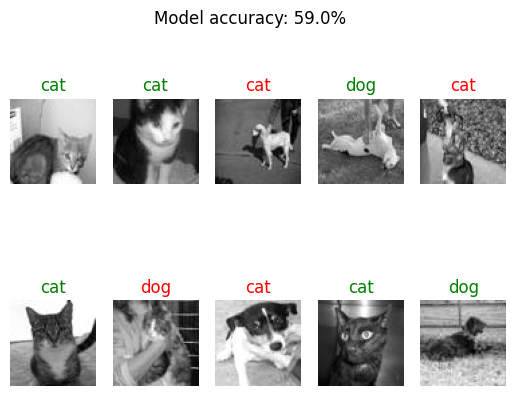

In [40]:
# === Functional code ===
model = build_model()
model.set_weights(WEIGHTS)

fig, axs = plt.subplots(2, 5)
accuracy = round(model.evaluate(X_TEST, Y_TEST)[1] * 100,2)
fig.suptitle(f"Model accuracy: {accuracy}%")

classes = ['cat', 'dog']
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(X_TEST[i].reshape(64, 64), cmap='gray')
    prediction = model.predict(X_TEST[i].reshape(1, 64, 64, 1))
    prediction = classes[1-np.argmax(prediction[0])]
    actual = classes[(Y_TEST[i][0])]
    print(f"Prediction: {prediction}")
    print(f"Actual: {actual}")
    ax.set_title(prediction, color='green' if prediction == actual else 'red')
    ax.axis('off')

fig.canvas.draw()
IMAGE = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# Input: WEIGHTS, X_TEST, Y_TEST
# Output: IMAGE

In [ ]:
# === Export data ===
if not os.path.exists("model"):
    os.makedirs("model")

IMAGE.save("model/evaluation.png")